In [6]:
import pandas as pd
import polars as pl
import polars.selectors as cs
import numpy as np
import plotnine as pn
from mizani.formatters import comma_format, custom_format, currency_format, percent_format
from IPython.display import clear_output, display
import os
import glob
from skimpy import clean_columns

jama_colour = [
    "#374e55",
    "#df8f44",
    "#00a1d5",
    "#b24745",
    "#79af97",
]

pd.set_option("display.max.columns", 500)
pd.set_option("display.max.columns", 500)
background_colour = "#F2F2F2"
pn.theme_set(
    pn.theme_classic()
    + pn.theme(
        figure_size=[7, 7/1.618],
        text=pn.element_text(family="monospace"),
        plot_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
        panel_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
        legend_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
    )
)


%load_ext blackcellmagic
%matplotlib inline

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [124]:
df = pd.read_excel("./5 EnergieEndverbrauch2009-2023.xlsx")

In [125]:
df = pl.from_pandas(df).sort("Zeitpunkt")

In [174]:
df = df.with_columns(pl.col("Zeitpunkt").dt.truncate("1h")).group_by("Zeitpunkt").agg(
    pl.sum("kWh")
)

Compare usual usage load profile on 24th of December to first two weeks of December by hour of day

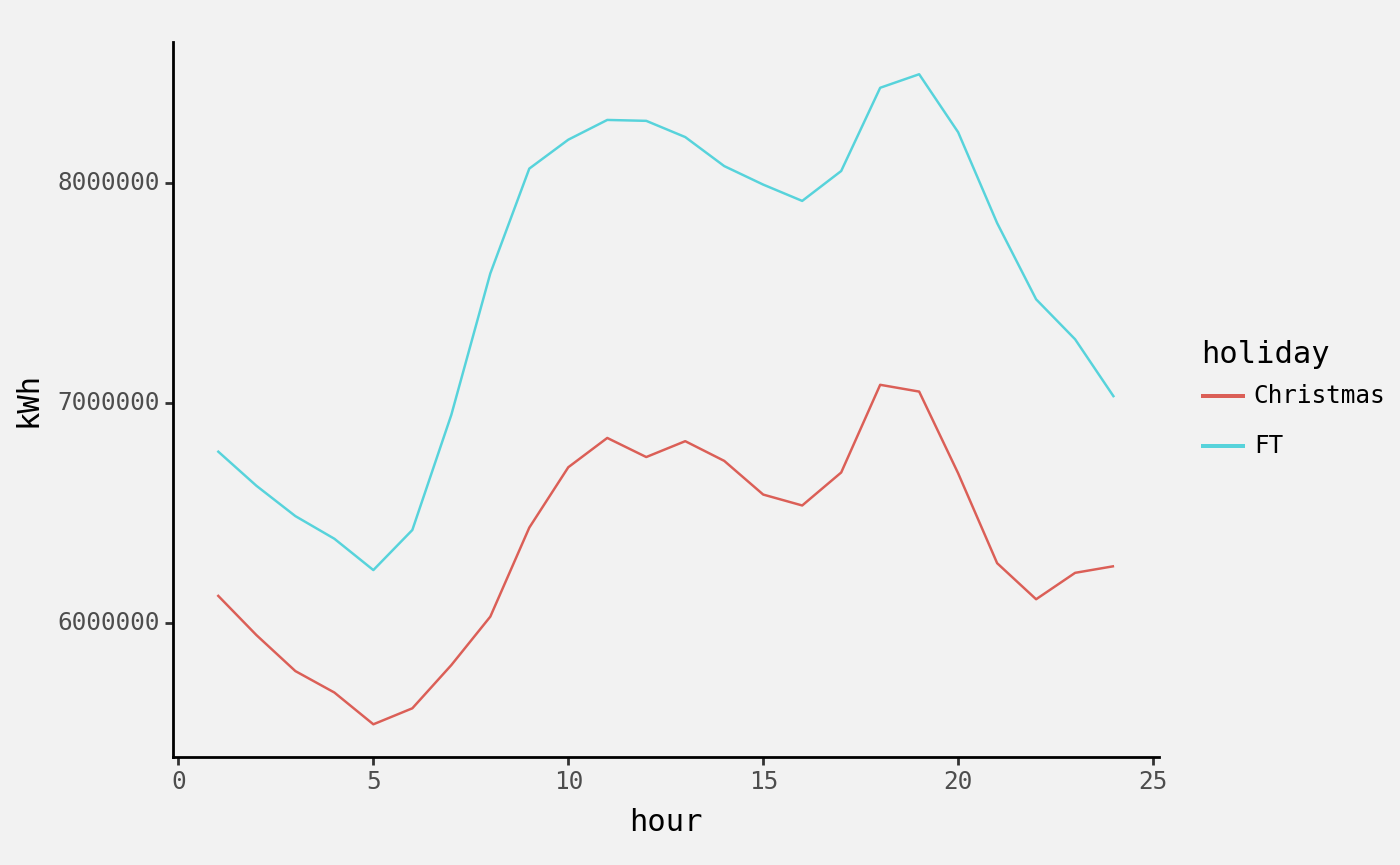

<Figure Size: (700 x 432)>

In [175]:
(
    pn.ggplot(
        (
            df.with_columns(
                pl.col("Zeitpunkt").dt.month().alias("month"),
                pl.col("Zeitpunkt").dt.day().alias("day"),
                (pl.col("Zeitpunkt").dt.hour() + 1).alias("hour"),
            )
            .with_columns(
                pl.when((pl.col("month") == 12) & (pl.col("day") == 24))
                .then(pl.lit("Christmas"))
                .when((pl.col("month") == 12) & (pl.col("day") < 24))
                .then(pl.lit("FT"))
                .alias("holiday")
            )
            .drop_nulls()
            .group_by(["hour", "holiday"])
            .agg(pl.mean("kWh"))
        ),
        mapping=pn.aes(x="hour", y="kWh", colour="holiday"),
    )
    + pn.geom_line()
)

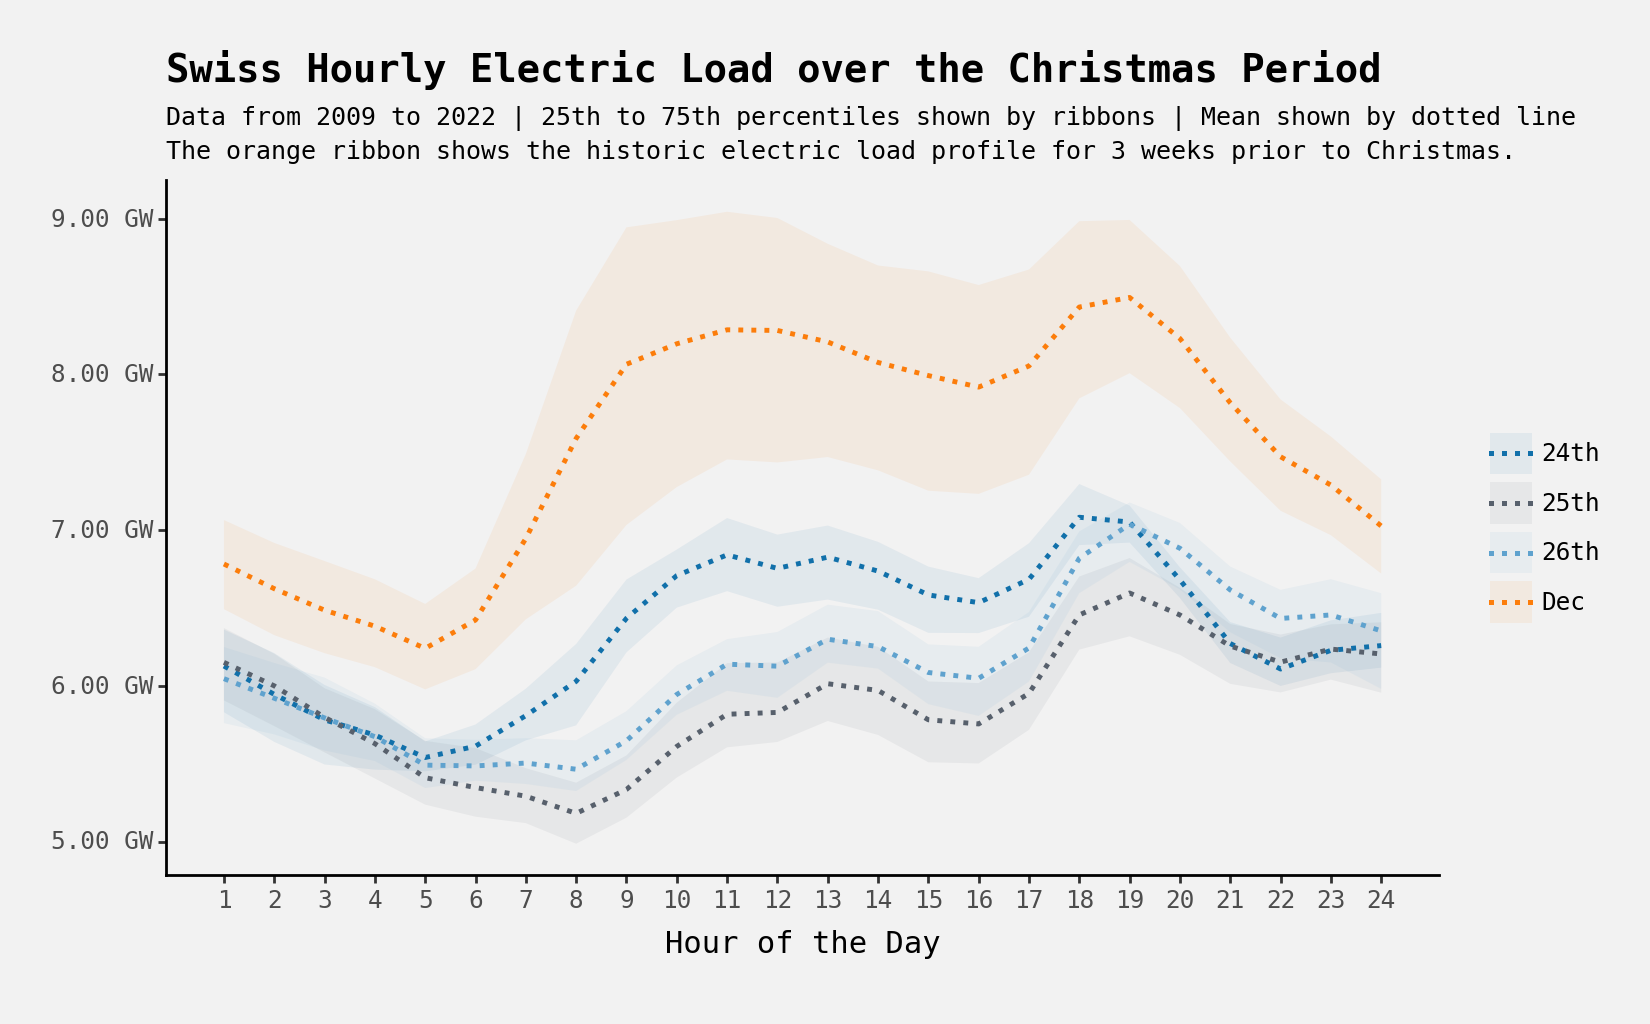

<Figure Size: (825 x 512)>

In [226]:
colours = ["#1170aa", "#57606c", "#5fa2ce", "#fc7d0b"]

p = (
    pn.ggplot(
        (
            df.with_columns(
                (pl.col("kWh") / 1_000_000).alias("GW"),
                pl.col("Zeitpunkt").dt.month().alias("month"),
                pl.col("Zeitpunkt").dt.day().alias("day"),
                (pl.col("Zeitpunkt").dt.hour() + 1).alias("hour"),
            )
            .with_columns(
                pl.when((pl.col("month") == 12) & (pl.col("day") == 24))
                .then(pl.lit("24th"))
                .when((pl.col("month") == 12) & (pl.col("day") == 25))
                .then(pl.lit("25th"))
                .when((pl.col("month") == 12) & (pl.col("day") == 26))
                .then(pl.lit("26th"))
                .when((pl.col("month") == 12) & (pl.col("day") < 24))
                .then(pl.lit("Dec"))
                .alias("holiday")
            )
            .drop_nulls()
            .group_by(["hour", "holiday"])
            .agg(
                pl.col("GW").mean().alias("mean"),
                pl.col("GW").quantile(0.10).alias("10th"),
                pl.col("GW").quantile(0.25).alias("25th"),
                pl.col("GW").quantile(0.75).alias("75th"),
                pl.col("GW").quantile(0.90).alias("90th"),
            )
        ),
        mapping=pn.aes(x="hour"),
    )
    # + pn.geom_ribbon(pn.aes(ymin="10th", ymax="90th", fill="holiday"), alpha=0.075)
    + pn.geom_ribbon(pn.aes(ymin="25th", ymax="75th", fill="holiday"), alpha=0.075)
    + pn.geom_line(pn.aes(y="mean", colour="holiday"), linetype="dotted", size=1)
    + pn.labs(
        title="Swiss Hourly Electric Load over the Christmas Period",
        subtitle="Data from 2009 to 2022 | 25th to 75th percentiles shown by ribbons | Mean shown by dotted line\nThe orange ribbon shows the historic electric load profile for 3 weeks prior to Christmas.",
        x="Hour of the Day",
    )
    + pn.scale_x_continuous(breaks=np.arange(1, 25))
    + pn.scale_y_continuous(
        labels=currency_format(prefix="", digits=2, big_mark=",", suffix=" GW")
    )
    + pn.scale_fill_manual(values=colours)
    + pn.scale_colour_manual(values=colours)
    + pn.theme(
        legend_title=pn.element_blank(),
        figure_size=[[x, x/1.61] for x in [8.25]][0],
        plot_title=pn.element_text(size=14, weight="bold"),
        plot_subtitle=pn.element_text(size=9, lineheight=1.5),
        axis_title_y=pn.element_blank(),
        plot_margin=0.03,
    )
)

p

In [227]:
p.save("christmas.png", dpi=300)
p.save("christmas.pdf")

c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 8.25 x 5.124223602484472 in image.
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: christmas.png
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 8.25 x 5.124223602484472 in image.
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: christmas.pdf


PermissionError: [Errno 13] Permission denied: 'christmas.pdf'